In [17]:
from graph_gen import * 
from visualize_tools import *
from clique_functions import *

import gudhi
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, HTML

In [18]:
def cliques_up_to_d(G, max_dim):
    #TODO: Optimize this so that the vertexes and edges are added immediately, 
    # that way we only look for 3 and 4 dimensional cliques.
    cliques = []
    for node in G.nodes():
        for clique in cliques:
            if all(G.has_edge(node, n) for n in clique):
                new_clique = clique + [node]
                if len(new_clique) <= max_dim:
                    cliques.append(new_clique)
        cliques.append([node])
    return cliques

In [19]:
def gudhi_filtration(graph_filtration, N):
    clique_filtration = []
    
    for n, graph in enumerate(tqdm(graph_filtration)):
        current_cliques = cliques_up_to_d(graph[1], 4)
        current_clique_simplices = []
        for clique in current_cliques:
            if len(clique)>2 and len(clique)<5:
                current_clique_simplices.append(clique)
        clique_filtration.append((graph_filtration[n], current_clique_simplices))

    print("Cliques Computed")

    st = gudhi.SimplexTree()
    edges_used = []
    cliques_used = []

    print("Building Clique Complex")
    
    for alpha_n in tqdm(clique_filtration):
        alpha = alpha_n[0][0]
        edges = alpha_n[0][1].edges
        
        for edge in edges:
            if list(edge) in edges_used:
                pass
            else:
                st.insert(list(edge), filtration = alpha)
                edges_used.append(list(edge))
        cliques = alpha_n[1]
        for clique in cliques:
            if list(clique) in cliques_used:
                pass
            else:
                st.insert(list(clique), filtration = alpha)
                cliques_used.append(list(clique))
    return st

In [27]:
def g_betti_curve(persistence, dimension):
    betti_curve = []
    filtered_tuples = [(start, end) for dim, (start, end) in persistence if dim == dimension]

    if len(filtered_tuples) > 0:
        # Determine the overall time span for the plot
        min_start = min(start for start, _ in filtered_tuples)
        max_end = max(end if type(end) != float else 1 for _, end in filtered_tuples)  # Convert "inf" to 1
    
        num_points = max(1000, 2*len(filtered_tuples))
        # Create a range of x values for the plot
        x = np.linspace(0, 1, num_points)
        
        # Initialize the curve as an array of zeros
        curve = np.zeros_like(x)
        
        # Create step functions for each (start, end) range and sum them
        for start, end in filtered_tuples:
            curve += np.where((x >= start) & (x <= end), 1, 0)
    else:
        x, curve = [],[]
    return x, curve

In [21]:
N = 20
random_graph_matrix = generate_random_graph_matrix(N)
off_diag = get_off_diagonal_entries(random_graph_matrix)

In [22]:
edge_filtration = get_edge_filtration(off_diag)

In [23]:
graph_filtration = generate_graph_filtration(edge_filtration)

In [24]:
g_filtration = gudhi_filtration(graph_filtration, N)

100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 107.77it/s]


Cliques Computed
Building Clique Complex


100%|█████████████████████████████████████████████████████████████████████████████████| 190/190 [00:07<00:00, 23.90it/s]


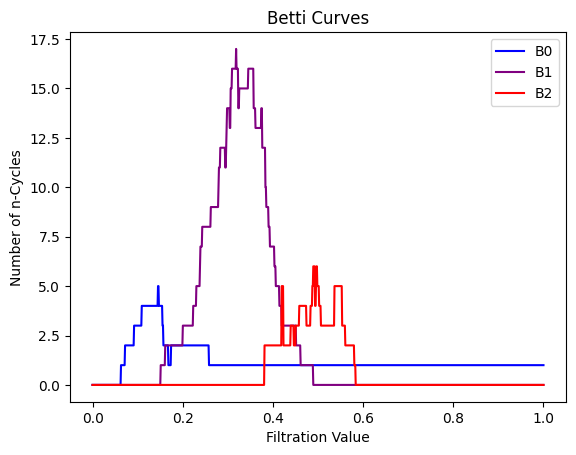

In [30]:
persistence = g_filtration.persistence(homology_coeff_field = 2, persistence_dim_max=True)

x0, b0 = g_betti_curve(persistence, 0)
x1, b1 = g_betti_curve(persistence, 1)
x2, b2 = g_betti_curve(persistence, 2)
x3, b3 = g_betti_curve(persistence, 3)


# Initialize a color map for distinguishing curves
color_map = plt.get_cmap('viridis')

# Create a figure and axis
fig, ax = plt.subplots()

ax.plot(x0, b0, label="B0", color="blue")
ax.plot(x1, b1, label="B1", color="purple")
ax.plot(x2, b2, label="B2", color="red")
# ax.plot(x3, b3, label="B3", color="orange")

# Set labels and legend
ax.set_xlabel('Filtration Value')
ax.set_ylabel('Number of n-Cycles')
ax.set_title('Betti Curves')
ax.legend()

plt.show()

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

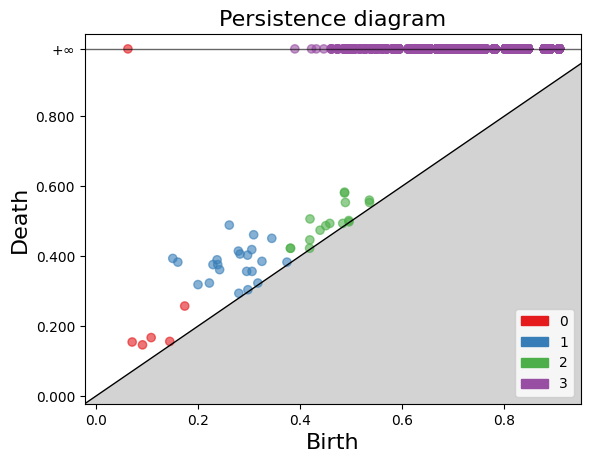

In [31]:
gudhi.plot_persistence_diagram(persistence_d)